In [2]:
#import library
import json,tweepy
import re
from unittest import result
import requests
from bs4 import BeautifulSoup
import pandas as pd
import string
from nltk.corpus import stopwords
import string
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk

Bussiness Understanding :
Minyak goreng merupakan kebutuhan primer dalam memasak bagi orang indonesia, namun belakangan harga minyak goreng melambung tinggi dan sangat susah untuk ditemukan dipasaran. Berdasarkan permasalahan itu saya ingin mengambil topik 'minyak goreng' untuk mengetahui sentimen masyarakat terhadap kelangkaan dan mahalnya minyak goreng di indonesia ahir-ahir ini. 


Data yang saya pakai berasal dari 2 sumber yakni Twitter dan Website Kompas.com
Twitter dengan kata kunci ‘Minyak Goreng’ yang akan mengambil tweet terbaru sebanyak 1000 tweet untuk menjadi data df_tweet
Website Kompas.com dengan keyword ‘Minyak Goreng’ yang akan mengambil halaman 1-3 dari hari ini, scapping tersebut mendapatkan 45 judul berita tentang minyak goreng


In [5]:
#membaca token dari token.json untuk mendapatkan akses API ke twitter

with open("token.json") as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

tokens.keys()

dict_keys(['api_key', 'api_key_secret', 'access_token', 'access_token_secret', 'bearer_token'])

In [13]:
#buat variabel authentikasi dan api
auth = tweepy.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [41]:
client = tweepy.Client(bearer_token=bearer_token)

# Replace with your own search query
query = 'minyak goreng -is:retweet'
df1= []
# Replace the limit=80 with the maximum number of Tweets you want
for tweet in tweepy.Paginator(client.search_recent_tweets, query=query,
                              tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=1000):
    df1.append(tweet.text)
    print(tweet.id, tweet.text)

1500302643675435008 @kiaspertama Jangan ke mars, minyak goreng lg susah disana
1500302554252537856 Berbondong bondong serang ikn berbondong bondong serang minyak  goreng berbondong bondong serang kribo berbondong  bondong serang yakut.. Yah gak kelar kelar besok ada lg masalah yg di antri antri kan. 
Yg sengsara rakyat juga tokoh nya masih bisa makan di cafe masih bisa jalan2
1500302548020113412 @kompascom Coba dicari di tempat orang vaksin yang bagi2 minyak goreng. Kemungkinan banyak yang disimpan di sana.
1500302531552899073 Angin Puting Beliung di Indramayu, Antrean Minyak Goreng Hingga Vaksinasi Calon Jemaah Haji! https://t.co/Cl13GnGsGA https://t.co/ictnq1X9yF
1500302519448530946 " ktika minyak goreng macih dlam proses stabilisasi distribusinya agar lancar mka kami minta bupati / wali kota te2p menggelar operasi minyak goreng , " kata khofifah.
1500302453715402753 Ndelok ng dunia maya minyak goreng langka jan antrine isok ngnu i edunn
1500302440041644032 @UyokBack 3 periode selesa

In [43]:
len(df1) #mengetahui banyak data
df_tweet = pd.DataFrame (df1, columns = ['tweets'])

In [44]:
df_tweet.head()

,tweets
0,"@kiaspertama Jangan ke mars, minyak goreng lg ..."
1,Berbondong bondong serang ikn berbondong bondo...
2,@kompascom Coba dicari di tempat orang vaksin ...
3,"Angin Puting Beliung di Indramayu, Antrean Min..."
4,""" ktika minyak goreng macih dlam proses stabil..."


In [47]:
#fungsi untuk pembersihan
def case_folding(data):
    data = data.lower()
    data = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", data).split())
    data = re.sub(r"\d+","", data)
    data = data.translate(str.maketrans("","",string.punctuation))
    data = re.sub(r"\n","",data)
    data = re.sub(r"\t","",data)
    return data
def stopword_cleaner(data):
    sw_indonesia = stopwords.words("indonesian")
    data = [word for word in data if word not in sw_indonesia]
    data = ' '.join(data)
    return data
def slang_cleaner(data, slang_list:list=[]):
    word_token = word_tokenize(data)
    word_list = []

    for word in word_token:
        for slang in slang_list:
            if word.lower() in slang[0].lower():
                word = slang[1]
                break
        word_list.append(word)

    data = ' '.join(word_list)
    return data

In [81]:
#fungsi analytic
def words_freq_distribution(data):
    data = data.apply(lambda x: word_tokenize(str(x)))
    tweets = [word for tweet in data for word in tweet]
    fqdist = FreqDist(tweets)
    most_common_word = fqdist.most_common(50)
    return most_common_word, tweets

def word_len_freq_distribution(data):
    bin_range = np.arange(0,50)
    plot_2 = plt.figure(2)
    data.str.split().map(lambda x: len(x)).hist(bins=bin_range)
    plt.title("Distribusi jumlah kata")
    
def mean_word_freq_distribution(data):
    plot_3 = plt.figure(3)
    data.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
    plt.title("Distribusi panjang kata rata-rata")

def bigram_freq_distribution(data):
    data_to_list = [word for news in data for word in news.split()]
    result = pd.Series(nltk.ngrams(data_to_list,2)).value_counts()[:20]
    return result

def char_freq_distribution(data):
    bins = np.arange(0,270,10)
    plot_1 = plt.figure(1)
    data.str.len().hist(bins=bins)
    plt.title("Distribusi jumlah huruf")


In [50]:
df_tweet["clean_tweet"] = df_tweet["tweets"].apply(lambda x: case_folding(x))
df_tweet["clean_tweet"] = df_tweet["clean_tweet"].apply(lambda x: word_tokenize(x))
df_tweet["clean_tweet"] = df_tweet["clean_tweet"].apply(lambda x: stopword_cleaner(x))

In [55]:
most_common_word = words_freq_distribution(df_tweet["clean_tweet"])
#print(most_common_word)

In [56]:
slang_list = [
    ('yg','yang'),
    ('umk','upah minimum kota'),
    ('aja','saja'),
    ('ya','iya'),
    ('gak','tidak'),
    ('ump','upah minimum provinsi'),
    ('kalo','kalau'),
    ('amp',''),
    ('jg','juga'),
    ('jd','jadi'),
    ('klo','kalau'),
    ('uu','undang-undang'),
    ('sih',''),
    ('udah','sudah'),
    ('dgn','dengan')
]

In [60]:
df_tweet["clean_tweet"] = df_tweet["clean_tweet"].apply(lambda x: slang_cleaner(x, slang_list))
df_tweet["clean_tweet"] = df_tweet["clean_tweet"].apply(lambda x: word_tokenize(x))
df_tweet["clean_tweet"] = df_tweet["clean_tweet"].apply(lambda x: stopword_cleaner(x))
#df_tweet.head()

C:\Users\LENOVO X260\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\LENOVO X260\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(minyak, goreng)        1040
(goreng, langka)          72
(antri, minyak)           43
(beli, minyak)            41
(jawa, timur)             41
(kelangkaan, minyak)      38
(ton, minyak)             30
(goreng, minyak)          30
(pemprov, jatim)          30
(harga, minyak)           30
(kabupaten, kota)         28
(ngantri, minyak)         22
(cari, minyak)            17
(gubernur, khofifah)      17
(goreng, susah)           17
(nyari, minyak)           16
(goreng, khofifah)        15
(pake, minyak)            14
(goreng, murah)           13
(stok, minyak)            13
dtype: int64


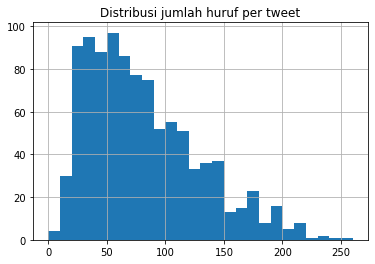

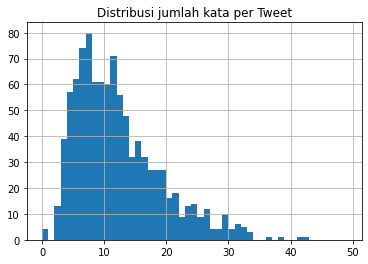

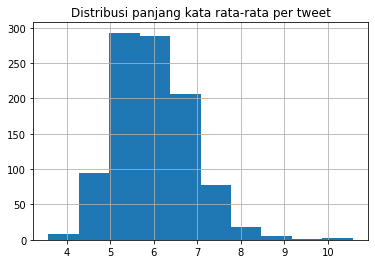

In [61]:
char_freq_distribution(df_tweet['clean_tweet'])
word_len_freq_distribution(df_tweet['clean_tweet'])
mean_word_freq_distribution(df_tweet['clean_tweet'])
bigram_result = bigram_freq_distribution(df_tweet['clean_tweet'])
print(bigram_result)

plt.show()

Dari data bigram tweet disamping dapat diberi kesimpulan bahwa banyak tweet yang berisi tentang minyak goreng, goreng langka, antri minyak, beli minyak, dll
Dapat disimpulkan bahwa
Banyak masyarakat yang mengantri untuk membeli minyak goreng, namun minyak goreng masih langka terutama di wilayah jawa timur


BERITA MINYAK GORENG DARI WEBSITE KOMPAS

In [64]:
url = "https://www.kompas.com/tag/minyak-goreng?sort=desc"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

results = soup.find("div", class_="latest--topic mt2 clearfix") #tabel
#print(results)
berita = results.find_all("a", class_="article__link")  #judul artikel
print("Judul Berita Populer : ")
urutan = 1
df = []
for berita in berita:
    title=berita.text
    print(urutan,title)
    df.append(
        {
            'title':title
        }
    )
    urutan+=1
df1 = pd.DataFrame(df)

Judul Berita Populer : 
1 Operasi Pasar Murah Minyak Goreng di Bengkulu Berujung Ricuh
2 Bisa Jadi Pengganti Minyak Goreng, Ini Manfaat Minyak Kelapa bagi Kesehatan
3 Begini Cara Cek Kualitas Minyak Goreng, Gunakan Mentega
4 Satpol PP dan Satlinmas Bagikan 2.550 Liter Minyak Goreng Gratis untuk Warga Surabaya
5 Gubernur Khofifah Kaget, Ada Warga Bawa Dandang Nasi Ketika Mengantre Minyak Goreng di Pasuruan
6 Disperindag DI Yogyakarta Mulai Petakan Spekulan Minyak Goreng
7 Distribusi Minyak Goreng di Kabupaten Bandung Telambat, Ini Penyebabnya
8 53 Ton Minyak Goreng yang Diduga Ditimbun di Sulteng Didistribusikan ke Pasaran
9 Polres Jaksel Gelar Operasi Minyak Selama 6 Hari, 150.000 Liter Disediakan untuk Warga
10 Kemendag Ungkap Penyebab Mengapa Harga Minyak Goreng Belum Merata di Pasaran
11 Minyak Goreng Langka, Polres Metro Jaksel Gelar Operasi Pasar di Lokasi Berikut...
12 Terbongkarnya Penimbunan Puluhan Ribu Liter Minyak Goreng di Lebak dan Palu…
13 [HOAKS] Kuis Berhadiah Rp 2 Juta

In [65]:
url = "https://www.kompas.com/tag/minyak-goreng?sort=desc&page=2"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

results = soup.find("div", class_="latest--topic mt2 clearfix") #tabel
#print(results)
berita = results.find_all("a", class_="article__link")  #judul artikel
print("Judul Berita Populer : ")
urutan = 1
df = []
for berita in berita:
    title=berita.text
    print(urutan,title)
    df.append(
        {
            'title':title
        }
    )
    urutan+=1
df2 = pd.DataFrame(df)

Judul Berita Populer : 
1 Timbun 24.000 Liter Minyak Goreng di Rumahnya, Warga Lebak Jadi Tersangka
2 Satgas Bongkar Dugaan Penimbunan 53 Ton Minyak Goreng di Sulteng, Disimpan Sejak Oktober 2021
3 Warga di Kendari Berdesakan demi Mendapat Minyak Goreng di Kantor Bulog
4 Ini Jadwal dan Lokasi Operasi Pasar Minyak Goreng dan Daging Kerbau di Kota Tangerang
5 Ada Operasi Pasar Minyak Goreng di Kota Tangerang, Pemkot: Diutamakan untuk yang Ikut Vaksinasi
6 Minyak Goreng Langka, Masak Tanpa Minyak Bisa Jadi Pilihan Sehat
7 [POPULER MONEY] China Tetap Untung Meski Kereta Cepat Jakarta-Bandung Balik Modal 40 Tahun | Mobile Banking BCA Error
8 [POPULER BANDUNG] Kasus Penipuan Penjual Minyak Goreng | Menara Masjid Pemkab Tasikmalaya Roboh
9 Puan Maharani: Masalah Minyak Goreng Harus Selesai Sebelum Ramadhan
10 Kunjungan Kerja di Gresik, Puan Kunjungi Pabrik Pupuk hingga Minyak Goreng
11 Meski Pemkot Palembang Sudah Gencar Operasi Pasar, Warga Masih Kesulitan Cari Minyak Goreng
12 Minimarket di

In [66]:
url = "https://www.kompas.com/tag/minyak-goreng?sort=desc&page=3"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

results = soup.find("div", class_="latest--topic mt2 clearfix") #tabel
#print(results)
berita = results.find_all("a", class_="article__link")  #judul artikel
print("Judul Berita Populer : ")
urutan = 1
df = []
for berita in berita:
    title=berita.text
    print(urutan,title)
    df.append(
        {
            'title':title
        }
    )
    urutan+=1
df3 = pd.DataFrame(df)

Judul Berita Populer : 
1 Kemendag Beberkan "Biang Kerok" Pasokan Minyak Goreng Langka di Pasaran
2 Khofifah: kalau Cinta NKRI, Tolong Distribusikan Stok Minyak Goreng ke Masyarakat
3 Emak-emak Serbu Minyak Goreng di Pasar Murah Buleleng, 2.500 Liter Habis dalam Hitungan Jam
4 Kelurahan Kebon Melati Bagikan Minyak Goreng untuk Tarik Minat Warga Divaksinasi Dosis Pertama
5 Minyak Goreng Masih Langka, Antrean Terjadi di Kabupaten Bandung
6 Update Harga Pangan 1 Maret 2022: Telur, Cabai, Minyak Goreng hingga Gula Pasir Naik
7 Februari 2022 Alami Deflasi 0,02 Persen, Minyak Goreng Satu Harga Penyebabnya
8 [HOAKS] Alfamart Bagi-bagi Minyak Goreng Gratis dalam Rangka HUT ke-22
9 Pemkot Padang Gelar Operasi Pasar Minyak Goreng, Ini Jadwal dan Lokasinya
10 Stok Minyak di Jambi Aman, Warga Diminta Pakai Minyak Goreng Lokal
11 Begini Cara Negeri Jiran Malaysia Atasi Masalah Minyak Goreng
12 Warningsih Tempuh 40 Kilometer dan Menginap di Rumah Saudara demi Dapat 1 Liter Minyak Goreng
13 Daftar Ba

In [68]:
df_news = pd.concat([df1,df2,df3])
df_news = df_news.reset_index(drop=True)
df_news.head() #file news
#df_news.to_csv('news_minyak.csv', encoding="utf-8")

,title
0,Operasi Pasar Murah Minyak Goreng di Bengkulu ...
1,"Bisa Jadi Pengganti Minyak Goreng, Ini Manfaat..."
2,"Begini Cara Cek Kualitas Minyak Goreng, Gunaka..."
3,Satpol PP dan Satlinmas Bagikan 2.550 Liter Mi...
4,"Gubernur Khofifah Kaget, Ada Warga Bawa Dandan..."


In [71]:
df_news["clean_title"] = df_news["title"].apply(lambda x: case_folding(x))
df_news["clean_title"] = df_news["clean_title"].apply(lambda x: word_tokenize(x))
df_news["clean_title"] = df_news["clean_title"].apply(lambda x: stopword_cleaner(x))
#df_news.head()

In [74]:
most_common_word = words_freq_distribution(df_news["clean_title"])
#print(most_common_word)

In [77]:
df_news["clean_title"]= df_news["clean_title"].apply(lambda x: slang_cleaner(x, slang_list))
df_news["clean_title"] = df_news["clean_title"].apply(lambda x: word_tokenize(x))
df_news["clean_title"] = df_news["clean_title"].apply(lambda x: stopword_cleaner(x))
#df_news.head()

(minyak, goreng)        42
(operasi, pasar)         7
(goreng, langka)         5
(liter, minyak)          4
(pasar, minyak)          3
(gelar, operasi)         3
(stok, minyak)           2
(kabupaten, bandung)     2
(jaksel, gelar)          2
(kota, tangerang)        2
(pasokan, minyak)        2
(warga, kemendag)        2
(harga, minyak)          2
(goreng, gratis)         2
(ton, minyak)            2
(pasar, murah)           2
(cari, minyak)           2
(liter, habis)           1
(goreng, pasar)          1
(murah, buleleng)        1
dtype: int64


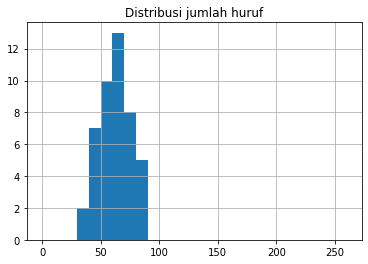

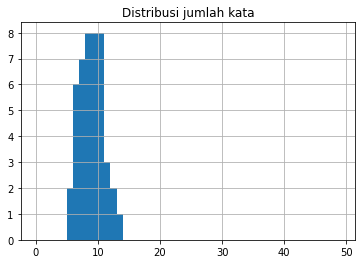

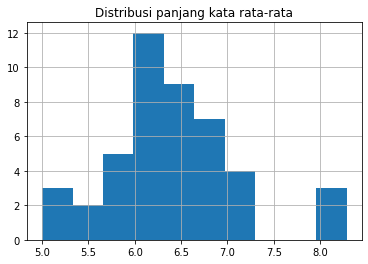

In [82]:
char_freq_distribution(df_news["clean_title"])
word_len_freq_distribution(df_news["clean_title"])
mean_word_freq_distribution(df_news["clean_title"])
bigram_result = bigram_freq_distribution(df_news["clean_title"])
print(bigram_result)

plt.show()

Dari data bigram news disamping dapat diberi kesimpulan bahwa banyak berita yang berisi tentang minyak goreng, operasi pasar, minyak langa, dll
Dapat disimpulkan bahwa
Masih banyak minyak goreng yang langka, dan pemerintah mulai rutin menggelar operasi pasar atau gelar operasi pasar. Kabupaten bandung, jaksel, dan kota tanggerang menjadi wilayah yang disebut dalam berita



In [79]:
#mengimport data ke dalam file csv
#Data Twitter
df_tweet.to_csv('tweet_minyak.csv', encoding="utf-8")
#Data Dari Berita
df_news.to_csv('news_minyak.csv', encoding="utf-8")

In [84]:
df_news.head()

,title,clean_title
0,Operasi Pasar Murah Minyak Goreng di Bengkulu ...,operasi pasar murah minyak goreng bengkulu ber...
1,"Bisa Jadi Pengganti Minyak Goreng, Ini Manfaat...",pengganti minyak goreng manfaat minyak kelapa ...
2,"Begini Cara Cek Kualitas Minyak Goreng, Gunaka...",cek kualitas minyak goreng mentega
3,Satpol PP dan Satlinmas Bagikan 2.550 Liter Mi...,satpol pp satlinmas bagikan liter minyak goren...
4,"Gubernur Khofifah Kaget, Ada Warga Bawa Dandan...",gubernur khofifah kaget warga bawa dandang nas...


#kesimpulan 

Dari data tweet maupun dari berita dapat disimpulkan bahwa masih terjadi kelangkaan minyak goreng diberbagai daerah terutama daerah jawa timur, akibat kelangkaan tersebut harga minyak goreng melambung tinggi. Di jawa Barat sudah mulai gencar melakukan operasi pasar guna melihat stok minyak goreng dan mengendalikan harga

#Saran

Sebaiknya pemerintah gencar melakukan operasi pasar diberbagai daerah untuk memantau stok dan harga dari minyak goreng dan juga menghindari adanya oknum yang menimbun minyak goreng.

